# Exercise 2 : Graph-based SLAM

The goal of this assignment is to implement a least-squares based method to address the SLAM problem in its graph-based formulation as explained in the lecture. 

We will consider 2D poses $(x, y, \theta)$ of the robot and 2D landmarks $(x_l, y_l)$ as the unknowns in our SLAM problem. The data is provided as a graph structure containing nodes (poses and landmarks) and constraints between these nodes (i.e pose-pose and pose-landmark). These datasets are stored as `dataset.g2o` text files. You are provided with the following datasets (see `data` folder), each of which represents the measurements of one SLAM problem.
1. `simulation-pose-pose.g2o`: simulated measurements containing pose-pose constraints only  
2. `simulation-pose-landmark.g2o`: simulated measurements containing both pose-pose and pose-landmark constraints
3. `intel.g2o`: real world measurements containing pose-pose constraints only
4. `dlr.g2o`: real world measurements containing both pose-pose and pose-landmark constraints

To get started with this task, we provide some Python code which will help in loading the graph structure, visualize it and other functions that you may need. We also provide additional notes `graph-slam-notes.pdf` which explains the Jacobian computations in detail.

## Task 2.0 Understanding the graph structure

Each graph consists of a set of nodes (or vertices) and edges that connect these nodes. As discussed in the lecture, the nodes correspond to the unknowns of the least-squares SLAM, whereas the edges correspond to the constraints obtained from the measurements.  In this assignment, the graph has the following types of nodes and edges:

1. Nodes:

    `VERTEX_SE2`: These nodes represent the 2D pose of the robot $(x, y, \theta)$

    `VERTEX_XY`: These nodes represent the 2D location of the landmark $(x_l, y_l)$
    
2. Edges:

    `EDGE_SE2`: These edges represent a constraint between two VERTEX_SE2 nodes. We refer to these edges as pose-pose constraints.
    
    `EDGE_SE2_XY`: These edges represent a constraint between a VERTEX_SE2 node and a VERTEX_XY node. We refer these edges as pose-landmark edge. 
    

In our code, we represent the graph as a class with the following attributes:
1. `nodes`: A dictionary of nodes where the information of each `node` can be accessed with `nodeId` as a key. Each `node` has a unique `nodeId`. This node can be either `VERTEX_SE2` or `VERTEX_XY`. If node has a dimension of 3, it represents the pose the robot (`VERTEX_SE2`). If the node has a dimension of 2, it represents the location of landmark (`VERTEX_XY`).
  
    
2. `edges`: A list of all the `edges` in the graph where each `edge` has the following attributes:

`Type`: The type is 'P' if the constraint is a pose-pose constraint (`EDGE_SE2`), whereas it is 'L' of it is a pose-landmark constraint (`EDGE_SE2_XY`).
`fromNode`: `nodeId` of the node from which the edge originates from.
`toNode`: `nodeId` of the node to which the edge terminates to.
`measurement`: The measurement corresponding to the edge.
`information`: The corresponding information matrix for the edge constraint.
    
3. `x`: All the unknowns (node variables) are stacked into a vector. This should be used for updating the state after each iteration of the optimization.

4. `lut`: This is a lookup table (implemented as a dictionary in Python). `lut[nodeId]` provides the starting location of the variables of the node with id `nodeId`.

Go through the examples in the cell below to understand how to work with the graph structure. Ensure that you understand how the graph is organized. This will be neccessary to solve all the tasks in the assignment. 

Loaded graph with 77 nodes and 297 edges


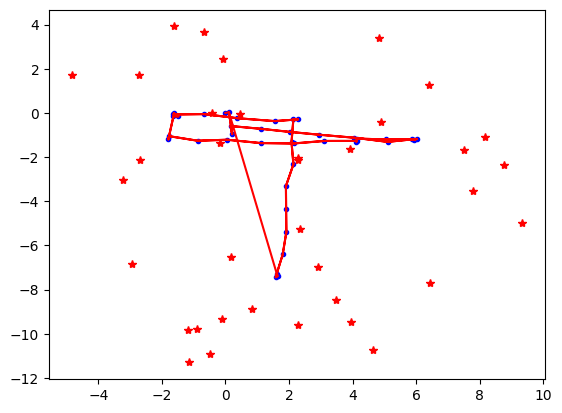

Loaded graph with 77 nodes and 297 edges
Node 128 = [ 0.378644 -0.23988  -0.0333  ] is a VERTEX_SE2 node
Node 128 from the state vector = [ 0.37864399 -0.23988    -0.0333    ]
Node 1 = [ 8.76682 -2.35679] is a VERTEX_XY node
Node 1 from the state vector = [ 8.76681995 -2.35679007]
Edge 0 = Edge(Type='P', fromNode=100, toNode=101, measurement=array([ 0.112639,  0.023666, -1.57066 ], dtype=float32), information=array([[ 100.,    0.,    0.],
       [   0.,  100.,    0.],
       [   0.,    0., 1000.]], dtype=float32)) is a pose-pose constraint
Edge 1 = Edge(Type='L', fromNode=101, toNode=4, measurement=array([0.050648, 0.357701], dtype=float32), information=array([[100.,   0.],
       [  0., 100.]], dtype=float32)) is a pose-landmark constraint


In [10]:
import ex2 as ex
import numpy as np
%matplotlib inline

# load a dataset 
filename = 'data/simulation-pose-landmark.g2o'
graph = ex.read_graph_g2o(filename)

# visualize the dataset
ex.plot_graph(graph)
print('Loaded graph with {} nodes and {} edges'.format(len(graph.nodes), len(graph.edges)))

# print information for the two types of nodes
nodeId = 128
print('Node {} = {} is a VERTEX_SE2 node'.format(nodeId, graph.nodes[nodeId]))

# access the state vector using the lookup table
fromIdx = graph.lut[nodeId]
print('Node {} from the state vector = {}'.format(nodeId,graph.x[fromIdx:fromIdx+3]))

nodeId = 1
print('Node {} = {} is a VERTEX_XY node'.format(nodeId, graph.nodes[nodeId]))

# access the state vector using the lookup table
fromIdx = graph.lut[nodeId]
print('Node {} from the state vector = {}'.format(nodeId, graph.x[fromIdx:fromIdx+2]))

# print information for two types of edges
eid = 0 
print('Edge {} = {} is a pose-pose constraint'.format(eid, graph.edges[eid]))

eid = 1 
print('Edge {} = {} is a pose-landmark constraint'.format(eid, graph.edges[eid]))

## Task 1.2.1 Computing total error. [5]

In this task, you have implement the function  `compute_global_error` function  for computing the current error value for a graph with constraints. Compute this error for all the four datasets and print the results. 

In [2]:
filenames = ["dlr.g2o", "intel.g2o", "simulation-pose-landmark.g2o", "simulation-pose-pose.g2o"]

for file in filenames:
    graph = ex.read_graph_g2o("data/"+file)
    print("Error for {} is {}".format(file,ex.compute_global_error(graph)))

Loaded graph with 3873 nodes and 17605 edges
Error for dlr.g2o is 4382432948.262865
Loaded graph with 1728 nodes and 4830 edges
Error for intel.g2o is 1795139.0277942903
Loaded graph with 77 nodes and 297 edges
Error for simulation-pose-landmark.g2o is 461709.04383489885
Loaded graph with 400 nodes and 1773 edges
Error for simulation-pose-pose.g2o is 138862240.4060366


## 1.2.2 Linearization of a Pose-Pose constraint [5]

Since the constraint described by the edge between two pose nodes is non-linear, you need to linearize it solve the least-squares optimization. The function `linearize_pose_pose_constraint` computes the error and the Jacobian for pose-pose constraint. It takes as input: 
   
    x1 : 3x1 vector 
         $(x,y,\theta)$ of the first robot pose
    x2 : 3x1 vector
         $(x,y,\theta)$ of the second robot pose
    z :  3x1 vector
         $(x,y,\theta)$ of the measurement
    
and returns

    e  : 3x1
         error of the constraint
    A  : 3x3
         Jacobian wrt x1
    B  : 3x3
         Jacobian wrt x2

Implement the `linearize_pose_pose_constraint` function and verify that it is correct. 

**Hint** : You can verify the Jacobian computation by comparing against a numerically Jacobian for your test data.


In [3]:
filename = 'data/simulation-pose-landmark.g2o'
g = ex.read_graph_g2o(filename)

edge = g.edges[0]

# pose-pose constraint
if edge.Type == 'P':

    # compute idx for nodes using lookup table
    fromIdx = g.lut[edge.fromNode]
    toIdx = g.lut[edge.toNode]

    # get node state for the current edge
    x1 = g.x[fromIdx:fromIdx + 3]
    x2 = g.x[toIdx:toIdx + 3]

    # get measurement and information matrix for the edge
    z12 = edge.measurement

# compute error and jacobians
e, A, B = ex.linearize_pose_pose_constraint(x1, x2, z12)
print(e)
print(A)
print(B)


Loaded graph with 77 nodes and 297 edges
[0.00000000e+00 0.00000000e+00 3.40797979e-12]
[[-1.36331713e-04  1.00000000e+00  1.12642229e-01]
 [-1.00000000e+00 -1.36331713e-04  2.36506437e-02]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]]
[[ 1.36331713e-04 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.36331713e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## 1.2.3 Linearization of a Pose-Landmark constraint [5]

Since the constraint described by the edge between a pose and landmark node is non-linear, you need to linearize it solve the least-squares optimization. The function `linearize_pose_landmark_constraint` computes the error and the Jacobian for pose-landmark constraint. It takes as input: 

    x : 3x1 vector
        (x,y,theta) og the robot pose
    l : 2x1 vector
        (x,y) of the landmark
    z : 2x1 vector
        (x,y) of the measurement
    
and returns:

    e : 2x1 vector
        error for the constraint
    A : 2x3 Jacobian wrt x
    B : 2x2 Jacobian wrt l
    
Implement the `linearize_and_solve` function and verify that it is correct. 

**Hint** : You can verify the Jacobian computation by comparing against a numerically Jacobian for your test data.

In [4]:
filename = 'data/simulation-pose-landmark.g2o'
g = ex.read_graph_g2o(filename)

edge = g.edges[1]

# pose-pose constraint
if edge.Type == 'L':

    # compute idx for nodes using lookup table
    fromIdx = g.lut[edge.fromNode]
    toIdx = g.lut[edge.toNode]

    # get node state for the current edge
    x = g.x[fromIdx:fromIdx + 3]
    l = g.x[toIdx:toIdx +2]

    # get measurement and information matrix for the edge
    z12 = edge.measurement

# compute error and jacobians
e, A, B = ex.linearize_pose_landmark_constraint(x, l, z12)
print(e)
print(A)
print(B)


Loaded graph with 77 nodes and 297 edges
[[7.66107455e-07]
 [7.94850152e-08]]
[[-1.36331715e-04  9.99999991e-01  3.57701083e-01]
 [-9.99999991e-01 -1.36331715e-04 -5.06487662e-02]]
[[ 1.36331715e-04 -9.99999991e-01]
 [ 9.99999991e-01  1.36331715e-04]]


## 1.2.4 Building and Solving Linearized System [5]

The `linearize_and_solve` function builds the $H$ and $b$ matrices in order to solve for $dx$ (i.e. change in the unknowns $x$) for one iteration. The function takes as input:

    g : graph at iteration i
    
and returns

    dx : Nx1 vector 
        change in the solution for the unknowns x

Implement the `linearize_and_solve` function. Some skeletal code for the function is already provided to you to start with.

In [5]:
filename = 'data/simulation-pose-landmark.g2o'
g = ex.read_graph_g2o(filename)

# compute error and jacobians
dx= ex.linearize_and_solve(g)
print(dx)

Loaded graph with 77 nodes and 297 edges
linearize and build system
[ 1.68515751e-01  5.74302703e-01 -5.08814924e-02 -3.67481274e-02
  8.89446687e-01  1.46275224e-01 -5.68193830e-03  8.14459391e-02
  6.83987693e-01  4.90075172e-01 -1.26613612e-01 -4.23884149e-03
  7.70789457e-01 -5.38033036e-03 -1.97203716e-01  2.84720420e-01
  2.50968944e-01  6.64986589e-01  1.81320663e-01 -1.10359468e-01
  1.06496762e+00  1.14687378e-01 -3.59193114e-01  1.43487999e-01
  9.37001132e-02 -1.12452352e-01  2.98405224e-02  2.94201707e-01
  9.71234501e-01  9.64883628e-01  2.90376355e-01  4.79224454e-01
  4.72465664e-01  3.05073459e-01 -5.59910851e-01  8.80649805e-02
 -1.53273542e-01  4.19638613e-01  2.93945294e-02 -1.07591514e-01
  1.88222199e-01  5.57943977e-01  2.34563501e-02 -1.25892847e-01
  2.64341291e-01  1.47996952e-01  4.68754206e-01 -1.48432690e-01
  1.73823975e-01  5.39290045e-01  6.85485869e-01  6.68341426e-01
 -3.30486968e-02  2.34466466e-01  1.11669539e-01 -2.40675196e-02
 -2.55007392e-01 -3.11

## 1.2.5 Iterative procedure for solving non-linear least squares [5]

The `run_graph_slam` function iteratively solves the least squares problem and updates the unknowns $x$. The procedure should be terminated if the change in $|dx| < 10^-4$ or the until a maximum number of iterations  (maxIter = 100) is reached. 

Implement the function `run_graph_slam` to perform the optimization. Some hints are provided as comments in the function. Test the function on the `simulation-pose-pose.g2o` and `simulation-pose-landmark.g2o` datasets. 

Loaded graph with 77 nodes and 297 edges
linearize and build system
Global error for step 0 : 441730.293093044

linearize and build system
Global error for step 1 : 438234.0739669565

linearize and build system
Global error for step 2 : 438215.1596896859

linearize and build system
Global error for step 3 : 438215.04943451844

linearize and build system
Global error for step 4 : 438215.0428355586

Converged
final error 438215.0428355586 



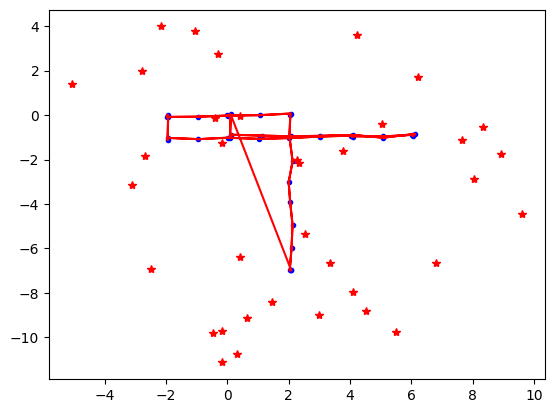

In [6]:
graph = ex.read_graph_g2o("data/simulation-pose-landmark.g2o")
ex.run_graph_slam(graph,100)


Loaded graph with 400 nodes and 1773 edges
linearize and build system
Global error for step 0 : 2321595.036841409

linearize and build system
Global error for step 1 : 29986.244965069232

linearize and build system
Global error for step 2 : 8308.491657161181

linearize and build system
Global error for step 3 : 8269.64530931319

linearize and build system
Global error for step 4 : 8269.437603183313

linearize and build system
Global error for step 5 : 8269.42161686996

linearize and build system
Global error for step 6 : 8269.42015326916

linearize and build system
Global error for step 7 : 8269.420012852388

linearize and build system
Global error for step 8 : 8269.41999914622

linearize and build system
Global error for step 9 : 8269.41999779512

Converged
final error 8269.41999779512 



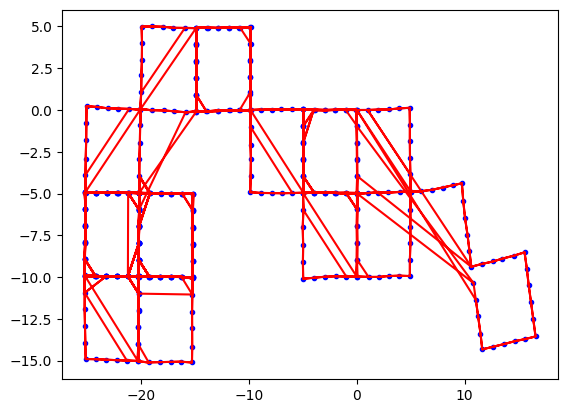

In [7]:
graph = ex.read_graph_g2o("data/simulation-pose-pose.g2o")
ex.run_graph_slam(graph,100)

Loaded graph with 1728 nodes and 4830 edges
linearize and build system
Global error for step 0 : 26716.53898211815

linearize and build system
Global error for step 1 : 398.3175219159352

linearize and build system
Global error for step 2 : 359.9971156582139

linearize and build system
Global error for step 3 : 359.9961126400161

linearize and build system
Global error for step 4 : 359.9961125527702

linearize and build system
Global error for step 5 : 359.9961125527491

Converged
final error 359.9961125527491 



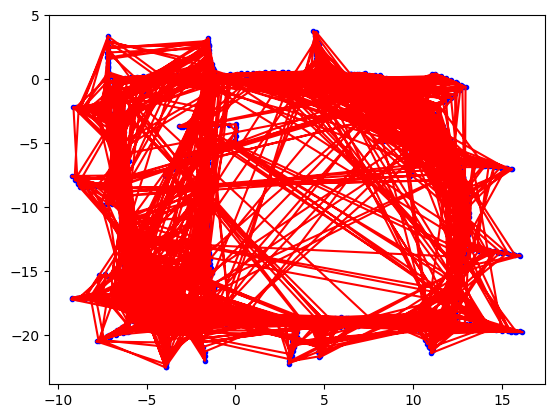

In [8]:
graph = ex.read_graph_g2o("data/intel.g2o")
ex.run_graph_slam(graph,100)

Loaded graph with 3873 nodes and 17605 edges
linearize and build system
Global error for step 0 : 6236566425.61275

linearize and build system
Global error for step 1 : 22279056258.788246

linearize and build system
Global error for step 2 : 4532576215.280772

linearize and build system
Global error for step 3 : 5208979118.026498

linearize and build system
Global error for step 4 : 4773854876.480814

linearize and build system
Global error for step 5 : 4514542599.212401

linearize and build system
Global error for step 6 : 4508673996.934569

linearize and build system
Global error for step 7 : 4508806426.552122

linearize and build system
Global error for step 8 : 4508784456.0835085

linearize and build system
Global error for step 9 : 4508783812.966587

linearize and build system
Global error for step 10 : 4508783544.290399

linearize and build system
Global error for step 11 : 4508783530.667164

Converged
final error 4508783530.667164 



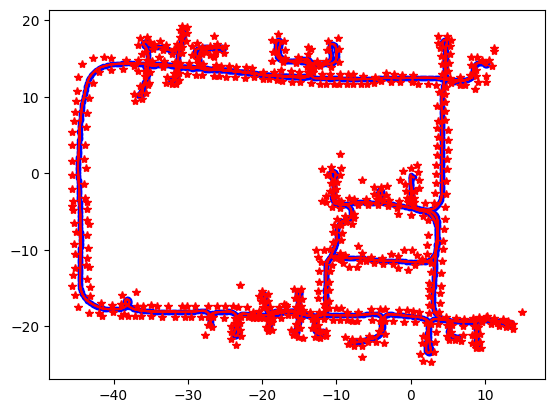

In [11]:

graph = ex.read_graph_g2o("data/dlr.g2o")
ex.run_graph_slam(graph,100)

## 1.2.6 Results for different datasets [5]

Evaluate the results of the graph-slam algorithm for all the four datasets. 

1. Create a `gif` animation visualing the results after each iteration. 
2. Plot the error vs iterations for all the datasets.

Please run your code locally and upload the `gifs` generated from your results in the cell below.

#### Simulated Pose-Pose
![Simulated pose pose](8269.41999779512.gif "Simulated pose-pose")

#### Simulated pose to landmark
![Sim pose to landmark](438215.0428355586.gif "sim pose to landmark")


#### Intel
![Intel](359.9961125527491.gif "Intel")


#### DLR
![DLR](4508783530.667164.gif "DLR")
